[*********************100%***********************]  1 of 1 completed


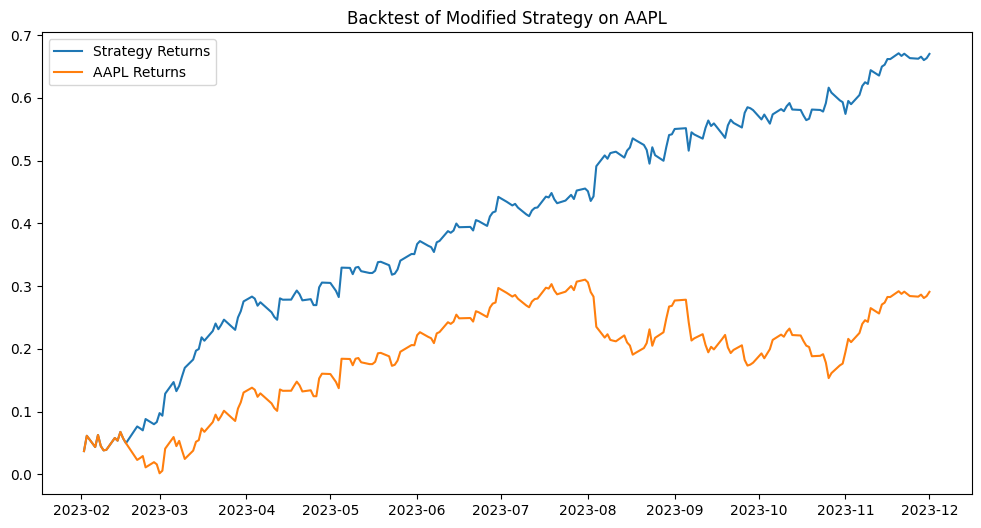

Total Return: 0.6701256585173256
Annualized Return: 0.8041507902207908
Maximum Drawdown: 0.04183202094539551
Sharpe Ratio: 4.090959849814381


In [46]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Fetch historical data for NOVN
novn_data = yf.download('AAPL', start='2023-01-01')

# Calculate the 21-day moving average for the opening price
novn_data['21_MA'] = novn_data['Close'].rolling(window=21).mean().shift(1)

# Strategy Logic
novn_data['Position'] = 0  # Default position is 0 (neutral)
novn_data.loc[novn_data['Close'] > novn_data['21_MA'], 'Position'] = 1  # Buy signal
novn_data.loc[novn_data['Close'] < novn_data['21_MA'], 'Position'] = -1  # Sell signal


# Calculate daily returns and strategy returns
novn_data['Daily_Return'] = novn_data['Close'].pct_change()
novn_data['Strategy_Return'] = novn_data['Daily_Return'] * novn_data['Position']

# Avoid look-ahead bias
novn_data = novn_data.dropna()

# Compute Performance Metrics
total_return = novn_data['Strategy_Return'].cumsum()[-1]
annualized_return = novn_data['Strategy_Return'].mean() * 252
max_drawdown = (novn_data['Strategy_Return'].cumsum().expanding().max() - novn_data['Strategy_Return'].cumsum()).max()
sharpe_ratio = novn_data['Strategy_Return'].mean() / novn_data['Strategy_Return'].std() * np.sqrt(252)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(novn_data['Strategy_Return'].cumsum(), label='Strategy Returns')
plt.plot(novn_data['Daily_Return'].cumsum(), label='AAPL Returns')
plt.title('Backtest of Modified Strategy on AAPL')
plt.legend()
plt.show()

# Print Performance Metrics
print(f'Total Return: {total_return}')
print(f'Annualized Return: {annualized_return}')
print(f'Maximum Drawdown: {max_drawdown}')
print(f'Sharpe Ratio: {sharpe_ratio}')


[*********************100%***********************]  1 of 1 completed
Trade log saved to 'trade_log.csv'.
    Entry_Date   Exit_Date  Entry_Price  Exit_Price     Return  \
0   2020-02-03  2020-02-04    77.165001   79.712502  -3.301368   
1   2020-02-04  2020-02-18    78.827499   78.839996   0.015854   
2   2020-02-18  2020-02-19    79.750000   80.904999  -1.448274   
3   2020-02-19  2020-02-21    80.000000   79.654999  -0.431252   
4   2020-02-21  2020-04-06    78.262497   65.617500  16.157160   
..         ...         ...          ...         ...        ...   
78  2023-08-03  2023-08-29   191.169998  184.119995   3.687819   
79  2023-08-29  2023-09-07   179.699997  175.179993  -2.515306   
80  2023-09-07  2023-10-06   177.559998  177.490005   0.039419   
81  2023-10-06  2023-10-19   173.800003  176.039993   1.288832   
82  2023-10-19  2023-11-02   175.460007  177.570007  -1.202554   

    Cumulative_Return  
0           -0.033014  
1           -0.032860  
2           -0.046867  
3     

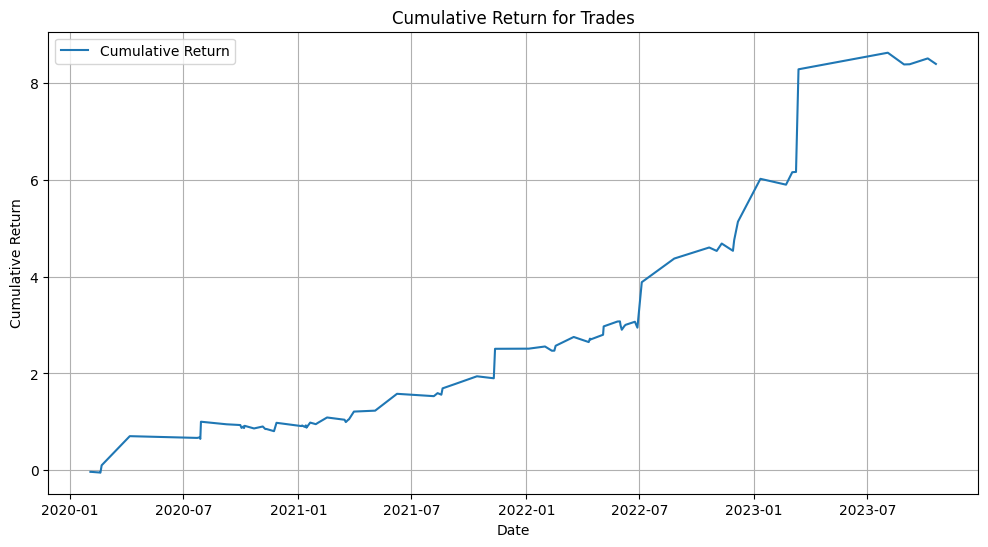

In [59]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Fetch historical data for AAPL
aapl_data = yf.download('AAPL', start='2020-01-01')

# Calculate the 21-day moving average for the closing price
aapl_data['21_MA'] = aapl_data['Close'].rolling(window=21).mean().shift(1)

# Strategy Logic
aapl_data['Position'] = 0  # Default position is 0 (neutral)
aapl_data.loc[aapl_data['Close'] > aapl_data['21_MA'], 'Position'] = 1  # Buy signal
aapl_data.loc[aapl_data['Close'] < aapl_data['21_MA'], 'Position'] = -1  # Sell signal

# Initialize a list to store trade details
trade_log_list = []

current_position = 0
entry_price = 0

for index, row in aapl_data.iterrows():
    # Check for a change in position
    if row['Position'] != current_position:
        if current_position != 0:
            # Record trade details when exiting a position
            exit_price = row['Open'] if current_position == 1 else row['Close']
            trade_return = (exit_price - entry_price) / entry_price if current_position == 1 else (entry_price - exit_price) / entry_price
            trade_log_list.append({'Entry_Date': entry_date, 'Entry_Price': entry_price, 'Exit_Date': index, 'Exit_Price': exit_price, 'Return': trade_return})
        if row['Position'] != 0:
            # Record trade details when entering a new position
            current_position = row['Position']
            entry_price = row['Open'] if current_position == 1 else row['Close']
            entry_date = index

# Convert the list of trade logs to a DataFrame
trade_log_df = pd.DataFrame(trade_log_list)

# Save the trade log DataFrame to a CSV file
trade_log_df.to_csv('trade_log.csv', index=False)

print("Trade log saved to 'trade_log.csv'.")

file_path = 'trade_log.csv'

# Read the CSV file into a DataFrame
trade_log_df = pd.read_csv(file_path)

# Ensure the 'Return' column is treated as a percentage
trade_log_df['Return'] = trade_log_df['Return'] * 100

# Calculate cumulative returns
trade_log_df['Cumulative_Return'] = (1 + trade_log_df['Return'] / 100).cumprod() - 1

# Extracting only the relevant columns for clarity
cumulative_returns_df = trade_log_df[['Entry_Date', 'Exit_Date', 'Entry_Price', 'Exit_Price', 'Return', 'Cumulative_Return']]

# To view the entire DataFrame
print(cumulative_returns_df)

# To get the final cumulative return for the trades
final_cumulative_return = cumulative_returns_df['Cumulative_Return'].iloc[-1]
print(f"Final Cumulative Return for Trades: {final_cumulative_return:.2f}%")

# Assuming you already have the cumulative_returns_df DataFrame
cumulative_returns_df['Entry_Date'] = pd.to_datetime(cumulative_returns_df['Entry_Date'])
cumulative_returns_df.set_index('Entry_Date', inplace=True)

# Plot the cumulative return curve
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns_df.index, cumulative_returns_df['Cumulative_Return'], label='Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Return for Trades')
plt.grid(True)
plt.legend()
plt.show()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


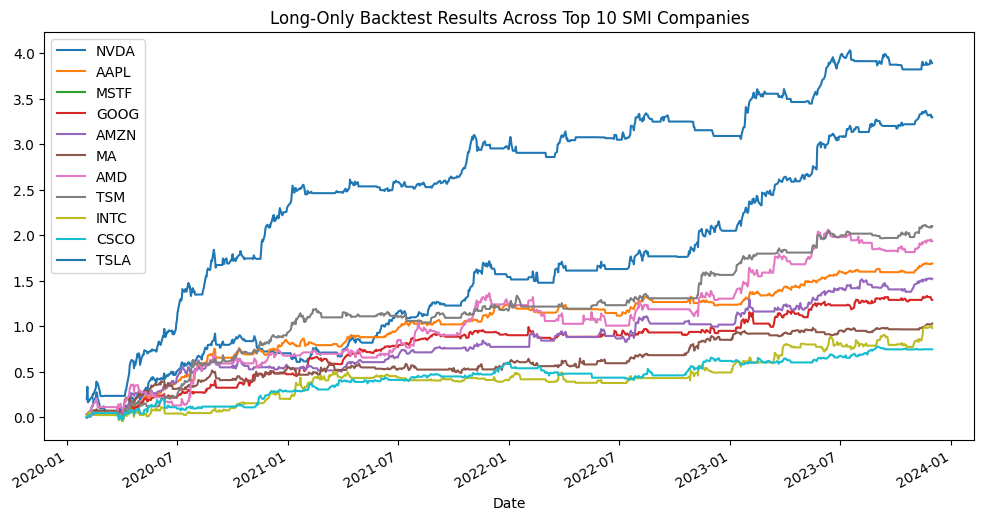

In [53]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# List of top 10 SMI companies by market cap (with their ticker symbols)
companies = ['NVDA', 'AAPL', 'MSTF', 'GOOG', 'AMZN', 'MA', 'AMD','TSM', 'INTC', 'CSCO', 'TSLA']

# Initialize a DataFrame to store aggregated results
aggregated_results = pd.DataFrame()

for company in companies:
    # Fetch historical data
    data = yf.download(company, start='2020-01-01')

    # Calculate the 21-day moving average
    data['21_MA'] = data['Close'].rolling(window=21).mean().shift(1)

    # Long-only Strategy Logic
    data['Position'] = 0
    data.loc[data['Open'] > data['21_MA'], 'Position'] = 1

    # Calculate returns
    data['Daily_Return'] = data['Close'].pct_change()
    data['Strategy_Return'] = data['Daily_Return'] * data['Position']

    # Drop NaN values to avoid look-ahead bias
    data = data.dropna()

    # Store the results
    aggregated_results[company] = data['Strategy_Return'].cumsum()

# Plot the aggregated results
aggregated_results.plot(figsize=(12, 6), title='Long-Only Backtest Results Across Top 10 SMI Companies')
plt.legend()
plt.show()


[*********************100%***********************]  9 of 9 completed


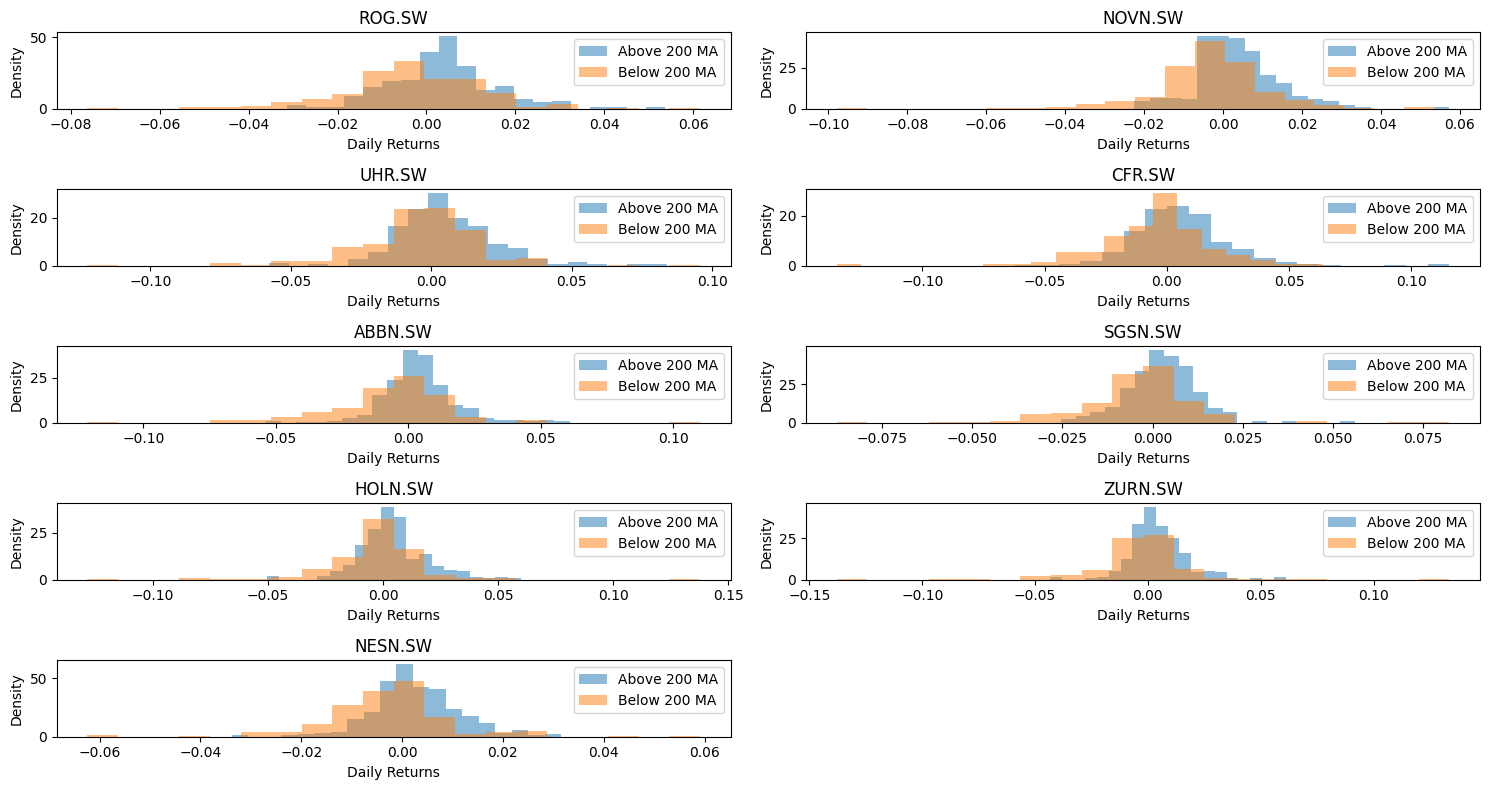

Cumulative Return: 372.49%
Annualized Return: 89.36%
Volatility: 16.00%
Sharpe Ratio: 5.58
Maximum Drawdown: 17.95%


In [17]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# List of S&P 100 symbols
sp100_symbols = ['ROG.SW', 'NOVN.SW', 'UHR.SW', 'CFR.SW', 'ABBN.SW', 
             'SGSN.SW', 'HOLN.SW', 'ZURN.SW', 'NESN.SW']

# Fetch historical data
start_date = '2020-01-01'
end_date = '2022-01-01'
data = yf.download(sp100_symbols, start=start_date, end=end_date)['Close']

# Calculate 200-day moving average and daily returns
ma = data.rolling(window=21).mean().shift(1)
daily_returns = data.pct_change()

# Classify returns based on the 200-day MA
returns_above_ma = daily_returns[data > ma]
returns_below_ma = daily_returns[data <= ma]

# Number of subplots (10 stocks per subplot)
num_plots = len(sp100_symbols) // 10
if len(sp100_symbols) % 10 != 0:
    num_plots += 1

# Plotting the distributions in subplots
for i in range(num_plots):
    plt.figure(figsize=(15, 8))
    for j in range(10):
        index = i * 10 + j
        if index >= len(sp100_symbols):
            break
        symbol = sp100_symbols[index]

        plt.subplot(5, 2, j + 1)  # 5 rows, 2 columns
        plt.hist(returns_above_ma[symbol].dropna(), bins=20, alpha=0.5, label='Above 200 MA', density=True)
        plt.hist(returns_below_ma[symbol].dropna(), bins=20, alpha=0.5, label='Below 200 MA', density=True)
        plt.title(symbol)
        plt.xlabel('Daily Returns')
        plt.ylabel('Density')
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
daily_returns = data.pct_change()

# Initialize DataFrame for strategy returns
strategy_returns = pd.DataFrame(index=daily_returns.index)

# Calculate daily returns when stock is above 21-day MA
for symbol in sp100_symbols:
    strategy_returns[symbol] = daily_returns[symbol].where(data[symbol] > ma[symbol])

# Calculate average daily return across all stocks
average_daily_return = strategy_returns.mean(axis=1)

# Calculate cumulative returns
cumulative_returns = (1 + average_daily_return).cumprod() - 1

# Performance metrics
annualized_return = average_daily_return.mean() * 252
volatility = average_daily_return.std() * np.sqrt(252)
sharpe_ratio = annualized_return / volatility
max_drawdown = (cumulative_returns.cummax() - cumulative_returns).max()

# Displaying the performance metrics
print(f"Cumulative Return: {cumulative_returns[-1]:.2%}")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Volatility: {volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
